# Project: Stock Market Prediction Using Deep Learning Techniques


# Load Python Packages Establish Random Seed, and Set Up CUDA Device

In [ ]:
# Required Libraries and Packages
import matplotlib.pyplot as plt
import sklearn as skl
import numpy as np

import torch
import torchinfo
import torch.nn as nn
import torch.optim as optim

from torch.utils.data import DataLoader, TensorDataset

from transformers import AutoModelForSequenceClassification, AutoTokenizer

from datetime import timedelta
import time

import yfinance as yf
import finnhub

# === PUT YOUR KEY HERE ===
finnhub_api_key = '' #<-- ENTER YOUR FINNHUB API KEY HERE

# Establish Seed for reproduceablity
seed = 42
torch.manual_seed(seed)

# Select Device for Computation (NVIDIA GPU or CPU)
if torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'
print(f'Selected Device: {device}')


Selected Device: cuda


# Data Collection and Processing

## Download SPY ETF Weekly Data (Friday Closes Only, for 6-years):

Using yFinance API.  More about API here: https://ranaroussi.github.io/yfinance/

In [2]:
ticker = 'SPY'
news_query = 'SPY OR "S&P 500" OR "Standard and Poors 500"'
spy = yf.Ticker(ticker)
df = spy.history(period='10y', interval='1d')
df = df[df.index.dayofweek == 4] #Keep Only Fridays
df = df[['Close', 'Volume']].copy()

test_close = df.iloc[-1, 0]

# drop last row for testing (suspress line if want to predict next week's return)
df = df[:-1] # Going back one additional week to see model performance against actual stock market returns.

df.tail()

,Close,Volume
Date,,
2025-10-31 00:00:00-04:00,682.059998,87164100
2025-11-07 00:00:00-05:00,670.969971,100592400
2025-11-14 00:00:00-05:00,671.929993,96846700
2025-11-21 00:00:00-05:00,659.030029,123956200
2025-11-28 00:00:00-05:00,683.390015,49212000


## Build Technical Features from SPY Weekly Information:

1) **Rolling Averages**
2) **Momentum**
3) **Volume**
4) **Relative Strength Index (RSI)**
5) **Moving Average Convergence Divergence (MACD)**

More about this can be found in articles at https://www.investopedia.com/.
   

In [3]:
def add_technical_features(df):
    df = df.copy()
    close = df['Close']
    volume = df['Volume']

    # Rolling statistics
    for weeks in [1, 2, 4]:
        df[f'close_ma_{weeks}w'] = close.rolling(window=weeks).mean()
        df[f'close_std_{weeks}w'] = close.rolling(window=weeks).std()
        df[f'volume_ma_{weeks}w'] = volume.rolling(window=weeks).mean()

    # Momentum (return over past N weeks)
    for weeks in [1, 2, 4]:
        df[f'momentum_{weeks}w'] = close.pct_change(periods=weeks)

    # --- RSI (weekly RSI) ---
    def weekly_rsi(series, period=14):
        delta = series.diff()
        gain = delta.where(delta > 0, 0)
        loss = -delta.where(delta < 0, 0)

        avg_gain = gain.rolling(period).mean()
        avg_loss = loss.rolling(period).mean()

        rs = avg_gain / avg_loss
        rsi = 100 - (100 / (1 + rs))
        return rsi

    # Weekly RSI for 1, 2, 4 "cycles"
    for w in [1, 2, 4]:
        period = w * 14 // 1   # 14-week RSI scaled (optional)
        df[f'rsi_{w}w'] = weekly_rsi(close, period=max(2, period))

    # --- MACD (weekly MACD) ---
    # Use weekly EMAs instead of daily 12/26-day EMAs
    df['macd'] = close.ewm(span=12, adjust=False).mean() - close.ewm(span=26, adjust=False).mean()
    df['macd_signal'] = df['macd'].ewm(span=9, adjust=False).mean()
    df['macd_hist'] = df['macd'] - df['macd_signal']

    # Establish Target Variable: Next Week's Return
    df['target'] = np.log(df['Close'].shift(-1) / df['Close'])

    df = df.drop('close_std_1w', axis=1) # Droping NaN heavy column.

    # Keep the last row even if it has NaN in 'target'
    df = df.dropna(subset=df.columns.difference(['target'])).copy()

    return df

df = add_technical_features(df)

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
price_cols = df.drop('target', axis=1).columns
df[price_cols] = scaler.fit_transform(df[price_cols])              

print(f'number of features: {df.shape[1]-1}') #exclude target
df.tail()


number of features: 19


,Close,Volume,close_ma_1w,volume_ma_1w,close_ma_2w,close_std_2w,volume_ma_2w,close_ma_4w,close_std_4w,volume_ma_4w,momentum_1w,momentum_2w,momentum_4w,rsi_1w,rsi_2w,rsi_4w,macd,macd_signal,macd_hist,target
Date,,,,,,,,,,,,,,,,,,,,
2025-10-31 00:00:00-04:00,2.411320,-0.033038,2.411320,-0.033038,2.403671,-0.264525,-0.215328,2.341000,1.379298,0.495567,0.158395,0.613511,0.152095,0.507555,1.919421,0.114598,1.993368,1.916200,0.718943,-0.016393
2025-11-07 00:00:00-05:00,2.324710,0.286670,2.324710,0.286670,2.379078,0.700744,0.146507,2.376315,0.227850,0.035380,-0.764860,-0.457225,0.330447,0.683250,1.422250,-0.056998,1.916369,1.952246,0.365173,0.001430
2025-11-14 00:00:00-05:00,2.332207,0.197490,2.332207,0.197490,2.339407,-0.856284,0.280045,2.391150,-0.308538,0.038085,-0.065739,-0.623773,-0.016940,0.421465,1.283648,-0.061651,1.833940,1.963228,0.068224,-0.019385
2025-11-21 00:00:00-05:00,2.231462,0.842927,2.231462,0.842927,2.292649,0.978939,0.602269,2.355303,0.599271,0.426069,-0.881000,-0.711626,-0.840300,-0.263731,0.774074,-0.280830,1.611748,1.923884,-0.528014,0.036297
2025-11-28 00:00:00-05:00,2.421707,-0.936621,2.421707,-0.936621,2.337528,2.740396,-0.054689,2.357920,0.711433,0.129196,1.338501,0.328714,-0.219246,0.219324,1.089492,-0.111078,1.649405,1.900566,-0.338147,NaN


## Download and Process News Information:

### Load Pre-Trained FinBERT-Tone Model:

**Brief Description:** "FinBERT is a BERT model pre-trained on financial communication text. The purpose is to enhance financial NLP research and practice. It is trained on the following three financial communication corpus. The total corpora size is 4.9B tokens.

    - Corporate Reports 10-K & 10-Q: 2.5B tokens
    - Earnings Call Transcripts: 1.3B tokens
    - Analyst Reports: 1.1B tokens"

**Hugging Face Documentation:** https://huggingface.co/yiyanghkust/finbert-tone 


In [4]:
# Establish Model:
checkpoint = 'yiyanghkust/finbert-tone'


In [5]:
# Download Model:
model = AutoModelForSequenceClassification.from_pretrained(
    checkpoint, 
    local_files_only=False,   # Can set this to True after you've downloaded the model once
    output_hidden_states = True
).to(device)

print(f'Loaded Model: {checkpoint}. Model info below.')

torchinfo.summary(model)


Loaded Model: yiyanghkust/finbert-tone. Model info below.


Layer (type:depth-idx)                                       Param #
BertForSequenceClassification                                --
├─BertModel: 1-1                                             --
│    └─BertEmbeddings: 2-1                                   --
│    │    └─Embedding: 3-1                                   23,710,464
│    │    └─Embedding: 3-2                                   393,216
│    │    └─Embedding: 3-3                                   1,536
│    │    └─LayerNorm: 3-4                                   1,536
│    │    └─Dropout: 3-5                                     --
│    └─BertEncoder: 2-2                                      --
│    │    └─ModuleList: 3-6                                  85,054,464
│    └─BertPooler: 2-3                                       --
│    │    └─Linear: 3-7                                      590,592
│    │    └─Tanh: 3-8                                        --
├─Dropout: 1-2                                               --
├─L

In [6]:
# Download Tokenizer:
tokenizer = AutoTokenizer.from_pretrained(
    checkpoint,
    local_files_only=False # Can set this to True after you've downloaded the tokenizer once
)

print(f'Loaded Tokenizer: {checkpoint}')


Loaded Tokenizer: yiyanghkust/finbert-tone


### Collect News for Each Friday using Finnhub API and Create Weekly Embedings using FinBERT:

More about Finnhub: https://finnhub.io


In [7]:
## Collect News Data
finnhub_client = finnhub.Client(finnhub_api_key)
NEWS_CATEGORY = 'general'  # Use 'general' for market-wide news


#################### Note ######################################
# Finnhub's free tier will only allow collection of news information up to 1 years back.  Paid plans can get up to 20+ years.

def get_weekly_news_embeddings(date):
    start = (date - timedelta(days=6)).strftime('%Y-%m-%d')
    end =  (date).strftime('%Y-%m-%d')

    try:
        if ticker:
            # Company-specific news
            news = finnhub_client.company_news(ticker, _from=start, to=end)
        else:
            # General market or category news
            news = finnhub_client.general_news(NEWS_CATEGORY, min_id=0)
            # Filter by date range (Finnhub general news doesn't support direct date filter, so we filter manually)
            news = [
                item for item in news
                if start <= item['datetime'][:10] <= end
            ]
        
        # Extract relevant text fields
        texts = []
        for article in news[:100]:  # Limit to avoid overload
            title = article.get('headline', '') or article.get('title', '')
            summary = article.get('summary', '') or article.get('description', '')
            texts.append(f"{title} {summary}".strip())

        full_text = " ".join(texts)

        if not full_text.strip():
            print(f"No news found for {start} to {end}")
            # Return zero embedding if no news
            return torch.zeros(768).to(device)  # Adjust size based on your model (e.g., BERT=768)

        inputs = tokenizer(full_text, return_tensors='pt', padding=True, truncation=True, max_length = 512).to(device)

        with torch.no_grad():
            outputs = model(**inputs)
            hidden_states = outputs.hidden_states
            last_hidden_state = hidden_states[-1]
        embedding = last_hidden_state.mean(dim=1).squeeze()
        return embedding

    except Exception as e:
        print(f"Error fetching news for {start} to {end}: {e}")
        return torch.zeros(768).to(device)  # Adjust size based on your model (e.g., BERT=768)

news_embeddings = []
for date in df.index:
    embedding = get_weekly_news_embeddings(date)
    news_embeddings.append(embedding)
    time.sleep(1)  # To respect API rate limits (60 API calls per minute with free tier)
news_embeddings = torch.stack(news_embeddings).to(device)

print(f"Collected {len(news_embeddings)} news embeddings | Shape: {news_embeddings.shape}")
        

No news found for 2017-01-14 to 2017-01-20
No news found for 2017-01-21 to 2017-01-27
No news found for 2017-01-28 to 2017-02-03
No news found for 2017-02-04 to 2017-02-10
No news found for 2017-02-11 to 2017-02-17
No news found for 2017-02-18 to 2017-02-24
No news found for 2017-02-25 to 2017-03-03
No news found for 2017-03-04 to 2017-03-10
No news found for 2017-03-10 to 2017-03-17
No news found for 2017-03-18 to 2017-03-24
No news found for 2017-03-25 to 2017-03-31
No news found for 2017-04-01 to 2017-04-07
No news found for 2017-04-15 to 2017-04-21
No news found for 2017-04-22 to 2017-04-28
No news found for 2017-04-29 to 2017-05-05
No news found for 2017-05-06 to 2017-05-12
No news found for 2017-05-13 to 2017-05-19
No news found for 2017-05-20 to 2017-05-26
No news found for 2017-05-27 to 2017-06-02
No news found for 2017-06-03 to 2017-06-09
No news found for 2017-06-10 to 2017-06-16
No news found for 2017-06-17 to 2017-06-23
No news found for 2017-06-24 to 2017-06-30
No news fou

# Establish Training and Test Sets and Establish Data Loaders

## Define X's and Y's

In [8]:
sequence_length = 4

def create_sequences(df, news_embeddings, seq_length=sequence_length):
    X_price = []
    X_news = []
    y = []
    
    price_features = df.drop('target', axis=1).values   # (N, 19)
    targets        = df['target'].values                # (N,)
    
    for i in range(seq_length, len(df)-1):
        X_price.append(price_features[i-seq_length:i])   # (12, 19)
        X_news.append(news_embeddings[i-seq_length:i])   # (12, 768)
        y.append(targets[i])
    
    return (np.stack(X_price),           # (samples, 12, 19)
            np.stack(X_news),            # (samples, 12, 768)
            np.array(y))                 # (samples,)

# Apply after you have df and news_embeddings
X_price_seq, X_news_seq, y_seq = create_sequences(df, news_embeddings.cpu().numpy(), seq_length=sequence_length)
print(X_price_seq.shape, X_news_seq.shape, y_seq.shape)

(444, 4, 19) (444, 4, 768) (444,)


## Establish Training/Test Sets and Data Loader

In [9]:
# Split into Train and Test Sets
X_news_train, X_news_test, X_price_train, X_price_test, y_train, y_test = skl.model_selection.train_test_split(
    X_news_seq, X_price_seq, y_seq,
    test_size=0.2,
    random_state=seed,
    shuffle=False   # important for time series!
)

# Convert to torch tensors
X_news_train  = torch.tensor(X_news_train,  dtype=torch.float32)
X_news_test   = torch.tensor(X_news_test,   dtype=torch.float32)
X_price_train = torch.tensor(X_price_train, dtype=torch.float32)
X_price_test  = torch.tensor(X_price_test,  dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
y_test  = torch.tensor(y_test,  dtype=torch.float32)

# Create DataLoaders
train_dataset = TensorDataset(X_news_train, X_price_train, y_train)
test_dataset  = TensorDataset(X_news_test,  X_price_test,  y_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader  = DataLoader(test_dataset,  batch_size=32, shuffle=False)

print(f'Training samples: {len(train_dataset)} and test samples: {len(test_dataset)}')

Training samples: 355 and test samples: 89


# Define the Model

1) **1-D CNN**
2) **News Embedding Compressor**
3) **RNN**

In [10]:
class SPY_Predictor(nn.Module):
    def __init__(self, price_dim=19, news_dim=768, hidden=128, dropout=0.3):
        super().__init__()
        
        # 1D CNN on price features
        self.cnn = nn.Sequential(
            nn.Conv1d(price_dim, 64, kernel_size=3, padding=1),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Conv1d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Conv1d(128, hidden, kernel_size=3, padding=1),
            nn.AdaptiveMaxPool1d(1)
        )

        # News embedding compressor
        self.news_proj = nn.Linear(news_dim, 64)

        # RNN
        self.rnn = nn.GRU(hidden + 64, hidden, num_layers=2,
                          batch_first=True, dropout=dropout, bidirectional=True)
        self.fc_mu  = nn.Linear(hidden*2, 1)
        self.dropout = nn.Dropout(dropout)

    def forward(self, price_seq, news_seq):
        # price_seq: (B, 52, price_dim)
        # news_seq:  (B, 52, 768)
        B, T, _ = price_seq.shape
        price_seq = price_seq.permute(0, 2, 1)  # (B, price_dim, 52)
        cnn_out = self.cnn(price_seq).view(B, -1)      # (B, hidden)
        cnn_out = cnn_out.unsqueeze(1).repeat(1, T, 1) # (B, 52, hidden)

        news_compressed = torch.tanh(self.news_proj(news_seq))  # (B, 52, 64)
        combined = torch.cat([cnn_out, news_compressed], dim=-1) # (B, 52, hidden+64)
        combined = self.dropout(combined)
        rnn_out, _ = self.rnn(combined) # (B, 52, hidden*2)
        final = rnn_out[:,-1,:]
        # last timestep
        mu = self.fc_mu(final).squeeze(-1)
        return mu

In [11]:
model = SPY_Predictor().to(device)

model

SPY_Predictor(
  (cnn): Sequential(
    (0): Conv1d(19, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv1d(64, 128, kernel_size=(3,), stride=(1,), padding=(1,))
    (4): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Conv1d(128, 128, kernel_size=(3,), stride=(1,), padding=(1,))
    (7): AdaptiveMaxPool1d(output_size=1)
  )
  (news_proj): Linear(in_features=768, out_features=64, bias=True)
  (rnn): GRU(192, 128, num_layers=2, batch_first=True, dropout=0.3, bidirectional=True)
  (fc_mu): Linear(in_features=256, out_features=1, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
)

# Training Loop and Testing Model Performance

In [12]:
# Train the Model:

optimizer = optim.Adam(model.parameters(), lr=0.000_001)    
criterion = nn.MSELoss()    # Set to MSE Loss for regression

num_epochs = 2000
for epoch in range(num_epochs):
    model.train()       # Set model to "training" mode
    train_loss = 0
    for batch_X_news, batch_X_price, batch_y in train_loader:
        batch_X_news, batch_X_price, batch_y = batch_X_news.to(device), batch_X_price.to(device), batch_y.to(device)   # Send the batch to the device
        optimizer.zero_grad()   # Reset gradient to zero
        # Forward Pass
        batch_y_hat = model(batch_X_price, batch_X_news) # Get current predictions
        loss = criterion(batch_y_hat, batch_y) # Compute loss
        # Backward Pass
        loss.backward()     # Compute (stochastic) gradient
        # Descent Step
        optimizer.step()    # Take gradient step (adjust parameters)
        # Update running total of loss
        train_loss += loss.item()

    if epoch % 100 == 0:
        print(f'Epoch {epoch:4d}: Mean Training Loss = {train_loss / len(train_loader):.5f}')

    

Epoch    0: Mean Training Loss = 0.01259
Epoch  100: Mean Training Loss = 0.00260
Epoch  200: Mean Training Loss = 0.00289
Epoch  300: Mean Training Loss = 0.00199
Epoch  400: Mean Training Loss = 0.00170
Epoch  500: Mean Training Loss = 0.00159
Epoch  600: Mean Training Loss = 0.00125
Epoch  700: Mean Training Loss = 0.00115
Epoch  800: Mean Training Loss = 0.00119
Epoch  900: Mean Training Loss = 0.00095
Epoch 1000: Mean Training Loss = 0.00079
Epoch 1100: Mean Training Loss = 0.00081
Epoch 1200: Mean Training Loss = 0.00098
Epoch 1300: Mean Training Loss = 0.00072
Epoch 1400: Mean Training Loss = 0.00075
Epoch 1500: Mean Training Loss = 0.00062
Epoch 1600: Mean Training Loss = 0.00055
Epoch 1700: Mean Training Loss = 0.00059
Epoch 1800: Mean Training Loss = 0.00054
Epoch 1900: Mean Training Loss = 0.00050


In [13]:
# Test the Model:

model.eval()
test_loss = 0
with torch.no_grad():
    for batch_X_news, batch_X_price, batch_y in test_loader:
        batch_X_news, batch_X_price, batch_y = batch_X_news.to(device), batch_X_price.to(device), batch_y.to(device)
        batch_y_hat = model(batch_X_price, batch_X_news)
        test_loss += criterion(batch_y_hat, batch_y).item()
        mean_test_loss = test_loss / len(test_loader)
        
print(f'Mean Test Loss = {mean_test_loss:.5f}')


Mean Test Loss = 0.00078


# Practical Application / Prediction

In [14]:
# Predict the next log return using the last sequence

# Take the LAST sequence_length weeks that we actually have data for
price_seq = df.drop('target', axis=1).values[-sequence_length:]      # shape (4, 19)
news_seq  = news_embeddings.cpu().numpy()[-sequence_length:]        # shape (4, 768)

# Add batch dimension
price_tensor = torch.tensor(price_seq, dtype=torch.float32).unsqueeze(0).to(device)  # (1,4,19)
news_tensor  = torch.tensor(news_seq,  dtype=torch.float32).unsqueeze(0).to(device)  # (1,4,768)

model.eval()
with torch.no_grad():
    pred_log_return = model(price_tensor, news_tensor).cpu().item()

# Last actual closing price
last_close_scaled = df[['Close']].iloc[-1:].values
last_close = scaler.inverse_transform(
    np.hstack([last_close_scaled, np.zeros((1, len(price_cols)-1))])
)[0, 0]

predicted_close = last_close * np.exp(pred_log_return)

print(f"Last observed date   : {df.index[-1].strftime('%Y-%m-%d')}  →  Close = ${last_close:.2f}")
print(f"Predicting           : {(df.index[-1] + timedelta(days=7)).strftime('%Y-%m-%d')}")
print(f"Predicted log return : {pred_log_return:+.5f}")
print(f"Predicted close      : ${predicted_close:.2f}({(predicted_close/last_close-1):.2%})")


Last observed date   : 2025-11-28  →  Close = $683.39
Predicting           : 2025-12-05
Predicted log return : +0.00359
Predicted close      : $685.84(0.36%)



Predicted SPY close on 2025-12-05:
  Point estimate      : $685.84(0.36%)
  80% prediction interval : $661.91(-3.14%) - $711.04(4.05%)
  Median of simulations   : $686.12(0.40%)


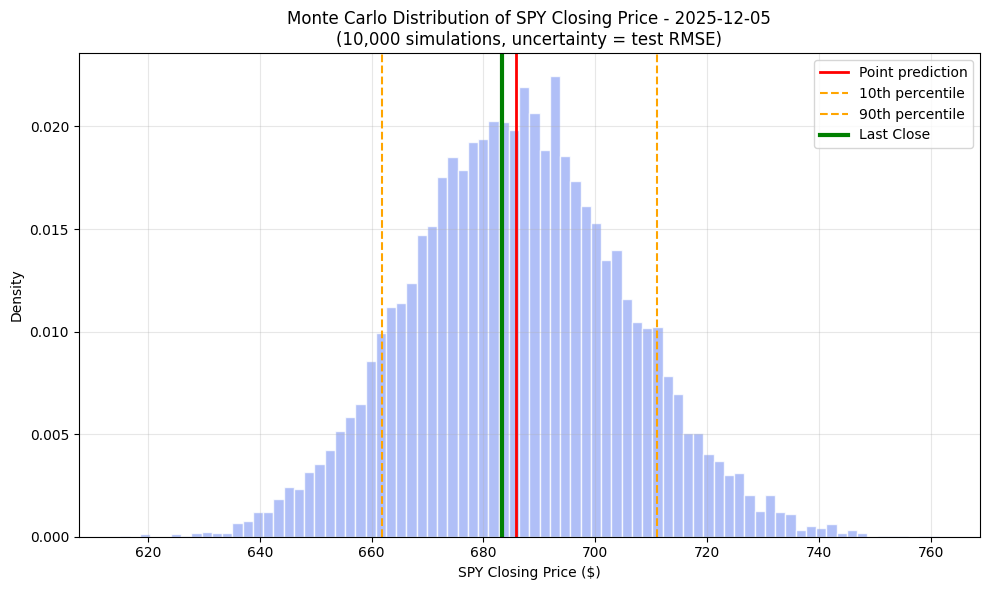

In [15]:
# Monte Carlo simulation

prediction_std = np.sqrt(mean_test_loss)  # Using this as std dev per your instructions
n_simulations = 10_000

# Simulate log returns
sim_log_returns = np.random.normal(pred_log_return, prediction_std, n_simulations)

# Compute simulated prices
sim_prices = last_close * np.exp(sim_log_returns)

# Percentiles for nice reporting
p10, p50, p90 = np.percentile(sim_prices, [10, 50, 90])

print(f"\nPredicted SPY close on {(df.index[-1] + timedelta(days=7)).strftime('%Y-%m-%d')}:")
print(f"  Point estimate      : ${predicted_close:6.2f}({(predicted_close/last_close-1):.2%})")
print(f"  80% prediction interval : ${p10:6.2f}({(p10/last_close-1):.2%}) - ${p90:6.2f}({(p90/last_close-1):.2%})")
print(f"  Median of simulations   : ${p50:6.2f}({(p50/last_close-1):.2%})")

# Plot
plt.figure(figsize=(10,6))
plt.hist(sim_prices, bins=80, density=True, alpha=0.8, color="#9caff5", edgecolor='white')
plt.axvline(predicted_close, color='red', linewidth=2, label='Point prediction')
plt.axvline(p10, color='orange', linestyle='--', label='10th percentile')
plt.axvline(p90, color='orange', linestyle='--', label='90th percentile')
plt.axvline(last_close, color='green', linewidth=3, label = 'Last Close')
plt.title(f'Monte Carlo Distribution of SPY Closing Price - {(df.index[-1] + timedelta(days=7)).strftime("%Y-%m-%d")}\n(10,000 simulations, uncertainty = test RMSE)')
plt.xlabel('SPY Closing Price ($)')
plt.ylabel('Density')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


In [16]:
# Compare Model Prediction to Actual Close on 2025-12-05
print(f'Actual Close of SPY on {(df.index[-1] + timedelta(days=7)).strftime("%Y-%m-%d")} was ${test_close:.2f} (a difference of ${(test_close-predicted_close):.2f})')


Actual Close of SPY on 2025-12-05 was $685.69 (a difference of $-0.15)
